## Bitflame Simulation

The Python implementation of the bitflame algorithmus.

In [208]:
%pip install numpy Pillow matplotlib

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from random import random
%matplotlib inline 


Note: you may need to restart the kernel to use updated packages.


## Parameters of the simulation

* The size (_WIDTH_ and _HEIGHT_) define the pixels used for the simulation.
* The _HEAT_ is a parameter spreading the fire. **Higher => more fire**
* The _CO2_ is a parameter extinguishing the fire. **Higher => less fire**
* The _CINDER_ defines how many pixel rows at the bottom are on constant fire serving as source.
* The _FADE_ flag switches between boolean images _{0, 1}_ and grayscale images _[0, 1]_. The gray-value is high when a lot of fire is around and low for isolated fires.


In [209]:
WIDTH = 320
HEIGHT = 120
HEAT = 0.2 # Chance to create fire in cell for each underlying fire cell
CO2 = 0.0008 # Chance to extinguish fire in cell per fire cell around
CINDER = 3
FADE = True
print(f"HEAT: {HEAT}, CO2: {CO2}")

HEAT: 0.2, CO2: 0.0008


#### Utility functions

In [210]:
def initMatrix():
    """Initialize a new matrix.
    
    Set all to 0 except the {CINDER} lowest rows which are always on fire.
    """
    mat = np.zeros((HEIGHT, WIDTH), dtype=np.float)
    mat[HEIGHT-CINDER:, :] = 1

    return mat

def nextMatrix(mat):
    """Calculate the next step of the matrix.
    
    The algorithm has 3 parts and is done in-place:
    
        1. All empty(=0) cells extinguish the cell above them.
            [x]       [o]
             ^    =>   ^
            [o]       [o]
        
        2. A cell can catch fire with a probability of {HEAT} for each full(=1) of the 3 cells below it.
             >  [o]  <        >  [x]  <
             ^   ^   ^   =>   ^   ^   ^
            [x] [x] [x]      [x] [x] [x]
        
        3. A full(=1) cell can extinguish any cell around it with a probability of {CO2}.
            [x] [x] [x]    [o] [x] [o]
            [x] [x] [x] => [o] [x] [o]
            [x] [x] [x]    [o] [o] [o]

    Those 3 steps stack and can overwrite the previous step.
    """
    # Spread fire
    for y in range(HEIGHT-CINDER):
        for x in range(WIDTH):
            # Bubble up no fire from underlying fire cell
            if mat[y+1,x] == 0:
                mat[y,x] = 0
                
            # Spread from 3 underlying fire cells            
            if x-1 >= 0 and mat[y+1,x-1] > 0:
                mat[y,x] = 1 if random() < HEAT else mat[y,x]
            if mat[y+1,x] > 0:
                mat[y,x] = 1 if random() < HEAT else mat[y,x]
            if x+1 < WIDTH and mat[y+1,x+1] > 0:
                mat[y,x] = 1 if random() < HEAT else mat[y,x]
                

    # Extinguish fire around
    for y in reversed(range(1, HEIGHT-CINDER)):
        for x in range(WIDTH):
            if x-1 >= 0 and mat[y-1,x-1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
            if x-1 >= 0 and mat[y,x-1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
            if x-1 >= 0 and mat[y+1,x-1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]

            if mat[y-1,x] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
            if mat[y+1,x] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]

            if x+1 < WIDTH and mat[y-1,x+1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
            if x+1 < WIDTH and mat[y,x+1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
            if x+1 < WIDTH and mat[y+1,x+1] > 0:
                mat[y,x] = 0 if random() < CO2 else mat[y,x]
                
    return mat

def fadeMatrix(mat):
    """Fade matrix based on fire proximity.
    
    Count the fire around each cell and set the value of the cell accordingly:
    val_cell[i] = sum(val_cell[i-1:i+1,i-1:i+1])/sum(cells_around)
    
    (For cells at the border, the cells_around gets adjusted accordingly so it is 1 when all 
    cells around are on fire, regardless or the count.)
    
    Creates a copy of the matrix and cannot be done in-place.
    """
    fadedMat = np.copy(mat)
    
    # Fade
    for y in range(HEIGHT):
        for x in range(WIDTH):
            if not mat[y,x]:
                continue
                
            c = 1
            a = 1
            
            if x-1 < 0 and y-1 >= 0:
                a = a + 1
                if mat[y-1,x-1] > 0:
                    c = c + 1
            if x-1 >= 0:
                a = a + 1
                if mat[y,x-1] > 0:
                    c = c + 1
            if x-1 >= 0 and y+1 < HEIGHT:
                a = a + 1
                if mat[y+1,x-1] > 0:
                    c = c + 1

            if y-1 >= 0:
                a = a + 1
                if mat[y-1,x] > 0:
                    c = c + 1
            if y+1 < HEIGHT:
                a = a + 1
                if mat[y+1,x] > 0:
                    c = c + 1

            if x+1 < WIDTH and y-1 >= 0:
                a = a + 1
                if mat[y-1,x+1] > 0:
                    c = c + 1
            if x+1 < WIDTH:
                a = a + 1
                if mat[y,x+1] > 0:
                    c = c + 1
            if x+1 < WIDTH and y+1 < HEIGHT:
                a = a + 1
                if mat[y+1,x+1] > 0:
                    c = c + 1

            fadedMat[y,x] = c / a


    return fadedMat

### Gif example

Create a GIF example based on the parameters.

In [211]:
N = 200 # The number of images
imgs = list(range(N+1))
data = initMatrix() 
imgs[0] = Image.fromarray(np.uint8(fadeMatrix(data) * 255))
for i in range(N):
    data = nextMatrix(data)
    imgs[i+1] = Image.fromarray(np.uint8(fadeMatrix(data) * 255))
imgs[0].save(f'fire_{HEIGHT}x{WIDTH}_heat={HEAT}_CO2={CO2}_cinder={CINDER}.gif', save_all=True, append_images=imgs)

### Small example

Small example which directly plots the images.

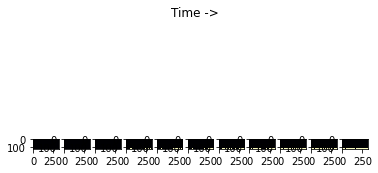

In [212]:
N = 10
fig, axes = plt.subplots(1, N+1)
data = initMatrix()
axes[0].imshow(data, interpolation='nearest', cmap="magma")
fig.suptitle('Time ->')
for i in range(N):
    data = nextMatrix(data)
    axes[i+1].imshow(data, interpolation='nearest', cmap="magma")
plt.show()